In [65]:
import torch
# import intel_extension_for_pytorch as ipex
from torch import nn as nn
from torch import Tensor
import math
from glob import glob
from torchinfo import summary
from torch_snippets import *
from torch_snippets.torch_loader import Report
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import WeightedRandomSampler
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import cohen_kappa_score
from PIL import Image
import cv2

In [66]:
#is GPU available?
gpu = torch.cuda.is_available()

#defining device where to to the computation
device = torch.device(0) if gpu else torch.device('cpu')

print(f'Using device: {device}')

Using device: cpu


### Randomly split a fileset into training, validation, and test sets: output lists of image names

In [67]:
# Set the folder with the samples (images) that compose a dataset and the number of classes

orig_dir   = '../larvae'
nclasses   = 2

# Set the desired image size for rescaling and maximum value for normalization

width       = 224
height      = 224
nchannels   = 3
maxval      = 255.
input_shape = (nchannels,height,width)

number_of_class_1 = 247
number_of_class_2 = 1351

# Set the percentages of samples that will be used for training, validation and test.

train_perc = 0.20
valid_perc = 0.10
test_perc  = 0.05

# Create training, validation, and test sets.

data = glob(orig_dir+"/*.png") # it returns a list of image filenames

num_train_samples = int(len(data)*train_perc)
num_valid_samples = int(len(data)*valid_perc)
num_test_samples  = int((len(data) - num_train_samples - num_valid_samples)*test_perc)
np.random.shuffle(data) # randomly change the order of the filenames in data
trainset = data[:num_train_samples]
validset = data[num_train_samples:num_train_samples+num_valid_samples]
testset  = data[num_train_samples+num_valid_samples:num_train_samples+num_valid_samples+num_test_samples]

print("------------------------------------------")
print(f"Total number of images:      {len(data)}")
print(f"Number of train images:      {len(trainset)}")
print(f"Number of validation images: {len(validset)}")
print(f"Number of test images:       {len(testset)}")
print("------------------------------------------")
# Set output model name

model_name  = 'FourthCNN.pth'

------------------------------------------
Total number of images:      1598
Number of train images:      319
Number of validation images: 159
Number of test images:       56
------------------------------------------


### Create image datasets with some preprocessing: output a list of image tensors

In [68]:
# Regular preprocessing transformation. The input is a PIL image, which after being resized,
# it is converted into a tensor for normalization using the ImageNet mean and stdev parameters.

prep = transforms.Compose([
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR,
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Such transformations are applied everytime images are loaded from the filename lists in training, validation,
# and test sets. We will do that during training, then by adding affine transformations and increasing the number
# of epochs, we are actually implementing data augmentation.

aug = transforms.Compose([
    transforms.Resize((300,300), interpolation=transforms.InterpolationMode.BILINEAR,
                      max_size=None, antialias=True),
    transforms.RandomAffine(degrees=10, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2),
                            interpolation=transforms.InterpolationMode.BILINEAR,
                            fill=0),
    transforms.CenterCrop(250),
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR,
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Create an image dataset by applying one of the preprocessing transformations above

class ImageDataset(): # there are three mandatory functions: init, len, getitem
    def __init__(self, dataset_filenames, transform=None): # Renamed dataset to dataset_filenames for clarity
        # it gets the image true labels and set the preprocessing transformation
        self.dataset = dataset_filenames
        print(self.dataset)
        self.targets = [int(str(x).split("/")[-1].split("_")[0])-1 for x in self.dataset]
        self.transform = transform
    def __len__(self): return len(self.dataset)
    def __getitem__(self, ix): # returns the item at position ix
        filename = self.dataset[ix]
        target   = self.targets[ix]
        image    = Image.open(filename).convert("RGB") # Ensure image is in RGB
        if (self.transform is not None):
            image = self.transform(image)
        else: # just reshape the image as a tensor with nchannels, height, width
            # Ensure proper handling if no transform is applied - e.g., if it's a grayscale image
            image = torch.from_numpy(np.array(image)).permute(2,0,1).float()
        return(image,target)

In [69]:
trainset = ImageDataset(trainset, aug) # verify the difference with and wothout data augmentation
validset = ImageDataset(validset, prep)
testset  = ImageDataset(testset, prep)

['../larvae/000001_00000195.png', '../larvae/000002_00000687.png', '../larvae/000002_00000365.png', '../larvae/000002_00000859.png', '../larvae/000002_00000990.png', '../larvae/000002_00000448.png', '../larvae/000002_00000787.png', '../larvae/000002_00000691.png', '../larvae/000002_00000037.png', '../larvae/000002_00000065.png', '../larvae/000002_00000793.png', '../larvae/000002_00000416.png', '../larvae/000001_00000211.png', '../larvae/000002_00000785.png', '../larvae/000002_00000573.png', '../larvae/000001_00000036.png', '../larvae/000002_00000107.png', '../larvae/000002_00000298.png', '../larvae/000002_00000678.png', '../larvae/000002_00000245.png', '../larvae/000002_00000463.png', '../larvae/000002_00000299.png', '../larvae/000002_00000772.png', '../larvae/000002_00000643.png', '../larvae/000002_00000352.png', '../larvae/000002_00000583.png', '../larvae/000001_00000111.png', '../larvae/000002_00001137.png', '../larvae/000002_00000527.png', '../larvae/000002_00000045.png', '../larva

In [70]:
print(trainset[0][0].shape, trainset[0][1]) # print the shape of the first image and its label

torch.Size([3, 224, 224]) 0


### Visualize selected images

Number of images: 319
Images are 224x224x3
Class of the image:  2


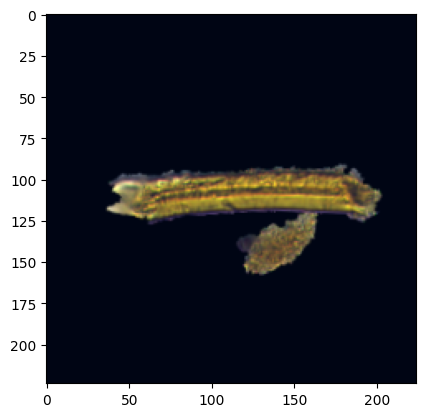

In [71]:
# visualize images from the trainset

print("Number of images:", len(trainset))
image, target = trainset[1] # it executes getitem
image     = image.permute(1,2,0).numpy()
image     = 255*(image - np.min(image))/(np.max(image)-np.min(image))
image     = image.astype('uint8')
print("Images are {}x{}x{}".format(width,height,nchannels))
plt.imshow(image)
print("Class of the image: ", target+1)
plt.show()

### Generate batches with batchsize images at random

In [72]:
batchsize = 32
trainload = DataLoader(trainset, batch_size=batchsize, shuffle=True)
testload  = DataLoader(testset, batch_size=batchsize, shuffle=True)
validload = DataLoader(validset, batch_size=batchsize, shuffle=True)

next(iter(trainload)) # inspect next item in the trainload

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
           [-

### InceptionNet model

In [73]:
class InceptionBlock(nn.Module):
    def __init__(self, in_channels):
        super(InceptionBlock, self).__init__()

        # Branch 1: convolution 1x1
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        # Branch 2: convolution 1x1 followed by 3x3
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 24, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(24),
            nn.ReLU()
        )

        # Branch 3: convolution 1x1 followed by 5x5
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, 8, kernel_size=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )

        # Branch 4: pooling followed by 1x1 convolution
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, 8, kernel_size=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )

    def forward(self, x):
        # Apply each branch to the input
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3(x)
        b4 = self.branch4(x)

        # Concatenate all results along the channel dimension
        return torch.cat([b1, b2, b3, b4], dim=1)

In [74]:
# a convolutional block
def conv_block(nchannels_in, nchannels_out, stride_val):
    return nn.Sequential(
        #defining convolutional layer
        nn.Conv2d(in_channels=nchannels_in, out_channels=nchannels_out, kernel_size=(3, 3),
                  stride=1, padding=1, bias=False),
        #defining a batch normalization layer, which dismisses the need for bias in the previous conv layer
        nn.BatchNorm2d(num_features=nchannels_out),
        #defining activation layer
        nn.ReLU(),
        #defining a pooling layer
        nn.MaxPool2d(kernel_size=(3, 3), stride=stride_val, padding=1)
    )

class FourthNet(nn.Module):

    def __init__(self, input_shape, num_classes):
        super(FourthNet, self).__init__()

        # Block Inception 1
        self.incept1 = nn.Sequential(
            InceptionBlock(input_shape[0]),
            nn.MaxPool2d(kernel_size=2, stride=2)  # reduces height/width by half
        )

        # Block Inception 2
        self.incept2 = nn.Sequential(
            InceptionBlock(56),  # 56 channels coming from the first block
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Block Inception 3
        self.incept3 = nn.Sequential(
            InceptionBlock(56),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Classifier fully connected
        h, w = input_shape[1] // 8, input_shape[2] // 8  # after 3 pooling (div by 2^3 = 8)
        self.classifier = nn.Sequential(
            nn.Linear(h * w * 56, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

        # Weight initialization
        self._initialize_weights()

    def forward(self, x):
        # Feature extraction with Inception blocks
        x = self.incept1(x)
        x = self.incept2(x)
        x = self.incept3(x)

        # Flatten to send to classifier
        x = torch.flatten(x, start_dim=1)
        y = self.classifier(x)

        return y

    def _initialize_weights(self):
        # Initialize weights with Normal He (for conv) and small std for linear
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                if m.bias is not None:
                    m.bias.data.zero_()

### Create the model

In [75]:
model = FourthNet(input_shape, nclasses).to(device)
summary(model,input_size=(1, *input_shape))

Layer (type:depth-idx)                   Output Shape              Param #
FourthNet                                [1, 2]                    --
├─Sequential: 1-1                        [1, 56, 112, 112]         --
│    └─InceptionBlock: 2-1               [1, 56, 224, 224]         --
│    │    └─Sequential: 3-1              [1, 16, 224, 224]         80
│    │    └─Sequential: 3-2              [1, 24, 224, 224]         3,584
│    │    └─Sequential: 3-3              [1, 8, 224, 224]          1,656
│    │    └─Sequential: 3-4              [1, 8, 224, 224]          40
│    └─MaxPool2d: 2-2                    [1, 56, 112, 112]         --
├─Sequential: 1-2                        [1, 56, 56, 56]           --
│    └─InceptionBlock: 2-3               [1, 56, 112, 112]         --
│    │    └─Sequential: 3-5              [1, 16, 112, 112]         928
│    │    └─Sequential: 3-6              [1, 24, 112, 112]         4,432
│    │    └─Sequential: 3-7              [1, 8, 112, 112]          2,080
│ 

### Define the loss function

In [76]:
weights = Tensor([1.0, number_of_class_1 / number_of_class_2]).to(device) # Adjust weights based on class imbalance
criterion = nn.CrossEntropyLoss(weight=weights)

### Define optimizer and learning scheduler

In [77]:
optimizer    = optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)

In [78]:
# Optimize model and optimizer for Intel hardware using IPEX
# model, optimizer = ipex.optimize(model, optimizer=optimizer, dtype=None, inplace=True)

### Clean up memory if needed

In [79]:
import gc
# del trainset, validset, testset
gc.collect()
torch.cuda.empty_cache()

### Define training and validation functions

In [80]:
def train_batch(model, data, optimizer, criterion, device):
    model.train()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss    = criterion(preds, targets)

    # Calculate accuracy
    acc = (preds.argmax(dim=1) == targets).float().mean()

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion, device):
    model.eval()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss    = criterion(preds, targets)

    acc = (preds.argmax(dim=1) == targets).float().mean()

    return loss.item(), acc.item()

### Load the model if it exists

In [81]:
# Load the model from the saved state dictionary
model = FourthNet(input_shape, nclasses).to(device)
model.load_state_dict(torch.load(model_name, map_location=device))

<All keys matched successfully>

### Train the model and report the results

In [82]:
# # initializing variables
# n_epochs = 50
# log      = Report(n_epochs)

# # starting training and validation
# for ex in range(n_epochs):
#     N = len(trainload)
#     for bx, data in enumerate(trainload):
#         loss, acc = train_batch(model, data, optimizer, criterion, device)
#         #report results for the batch
#         log.record((ex+(bx+1)/N), trn_loss=loss, trn_acc=acc, end='\r')

#     N = len(validload)
#     for bx, data in enumerate(validload):
#         loss, acc = validate_batch(model, data, criterion, device)
#         log.record((ex+(bx+1)/N), val_loss=loss, val_acc=acc, end='\r')

#     if (ex+1)%10==0: log.report_avgs(ex+1)
#     #count epochs for auto-adjusting the learning rate
#     lr_scheduler.step()

### Plot the results

In [83]:
# log.plot_epochs(['trn_loss','val_loss'])
# log.plot_epochs(['trn_acc','val_acc'])

### Evaluate the model

In [84]:
def Test(model, testload, criterion, device):
    N = len(testload)
    mean_loss = 0
    mean_acc  = 0
    for bx, data in enumerate(testload):
        loss, acc  = validate_batch(model, data, criterion, device)
        mean_loss += loss
        mean_acc  += acc
    mean_loss = mean_loss / N
    mean_acc  = mean_acc / N
    return(mean_loss, mean_acc)

(loss, acc) = Test(model, testload, criterion, device)
print('Loss: {:.6f} Acc: {:.6f}'.format(loss,acc))

Loss: 0.085424 Acc: 0.968750


### Cohen's Kappa statistics

In [85]:
# Cohen's Kappa statistics

def Kappa(model, testload, device):
    model.eval()
    y_true = []
    y_pred = []
    for data in testload:
        ims, targets = data
        ims     = ims.to(device=device)
        targets = targets.to(device=device)
        preds   = model(ims)
        pred_labels = torch.max(preds, 1)[1] # same as argmax
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(pred_labels.cpu().numpy())

    kappa = cohen_kappa_score(y_true, y_pred)
    return kappa

kappa = Kappa(model, testload, device)
print('Kappa: {:.6f}'.format(kappa))

Kappa: 0.837209


### Save the model

In [86]:
# torch.save(model.to('cpu').state_dict(), model_name)

### Visualize activations at the output of the last convolutional block for a given image

In [98]:
image, target = trainset[0]
image.size()

torch.Size([3, 224, 224])

In [99]:
image   = image.unsqueeze(0).to(device)

In [100]:
def get_net_feature_map(model, input_tensor: torch.Tensor) -> torch.Tensor:
    """
    Simple method: Extract feature map by calling model.features directly

    Args:
        model: ThirdNet model instance
        input_tensor: Input tensor

    Returns:
        Feature map from the feature extractor (before flattening)
    """
    model.eval()
    with torch.no_grad():
        x = model.incept1(input_tensor)
        x = model.incept2(x)
        x = model.incept3(x)
    return x

In [90]:
def visualize_net_features(feature_map: torch.Tensor,
                               max_channels: int = 16,
                               start_channel: int = 0,
                               figsize: tuple = (15, 10),
                               sample_idx: int = 0):
    """
    Visualize ThirdNet feature maps

    Args:
        feature_map: Feature map tensor (batch_size, channels, height, width)
        max_channels: Maximum number of channels to display
        start_channel: Starting channel index (0-based)
        figsize: Figure size for matplotlib
        sample_idx: Which sample from the batch to visualize
    """
    if feature_map.dim() == 4:
        feature_map_sample = feature_map[sample_idx]  # Shape: (channels, height, width)
    else:
        feature_map_sample = feature_map

    total_channels = feature_map_sample.shape[0]
    end_channel = min(start_channel + max_channels, total_channels)
    num_channels = end_channel - start_channel

    if start_channel >= total_channels:
        raise ValueError(f"start_channel ({start_channel}) must be less than total channels ({total_channels})")

    print(f"Feature map shape: {feature_map.shape}")
    print(f"Total channels: {total_channels}")
    print(f"Visualizing channels {start_channel}-{end_channel-1} from sample {sample_idx}")


    # Calculate grid dimensions
    cols = 4
    rows = (num_channels + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()

    for i in range(num_channels):
        ax = axes[i]
        channel_idx = start_channel + i
        channel_data = feature_map_sample[channel_idx].cpu().numpy()

        im = ax.imshow(channel_data, cmap='viridis')
        ax.set_title(f'Channel {channel_idx}\nMin: {channel_data.min():.2f}\nMax: {channel_data.max():.2f}',
                    fontsize=10)
        ax.axis('off')
        plt.colorbar(im, ax=ax, shrink=0.6)

    # Hide unused subplots
    for i in range(num_channels, len(axes)):
        axes[i].axis('off')

    plt.suptitle(f'ThirdNet Feature Maps - Channels {start_channel}-{end_channel-1}\nShape: {feature_map.shape}',
                 fontsize=14)
    plt.tight_layout()
    plt.show()

Feature map shape: torch.Size([1, 56, 28, 28])
Total channels: 56
Visualizing channels 40-55 from sample 0


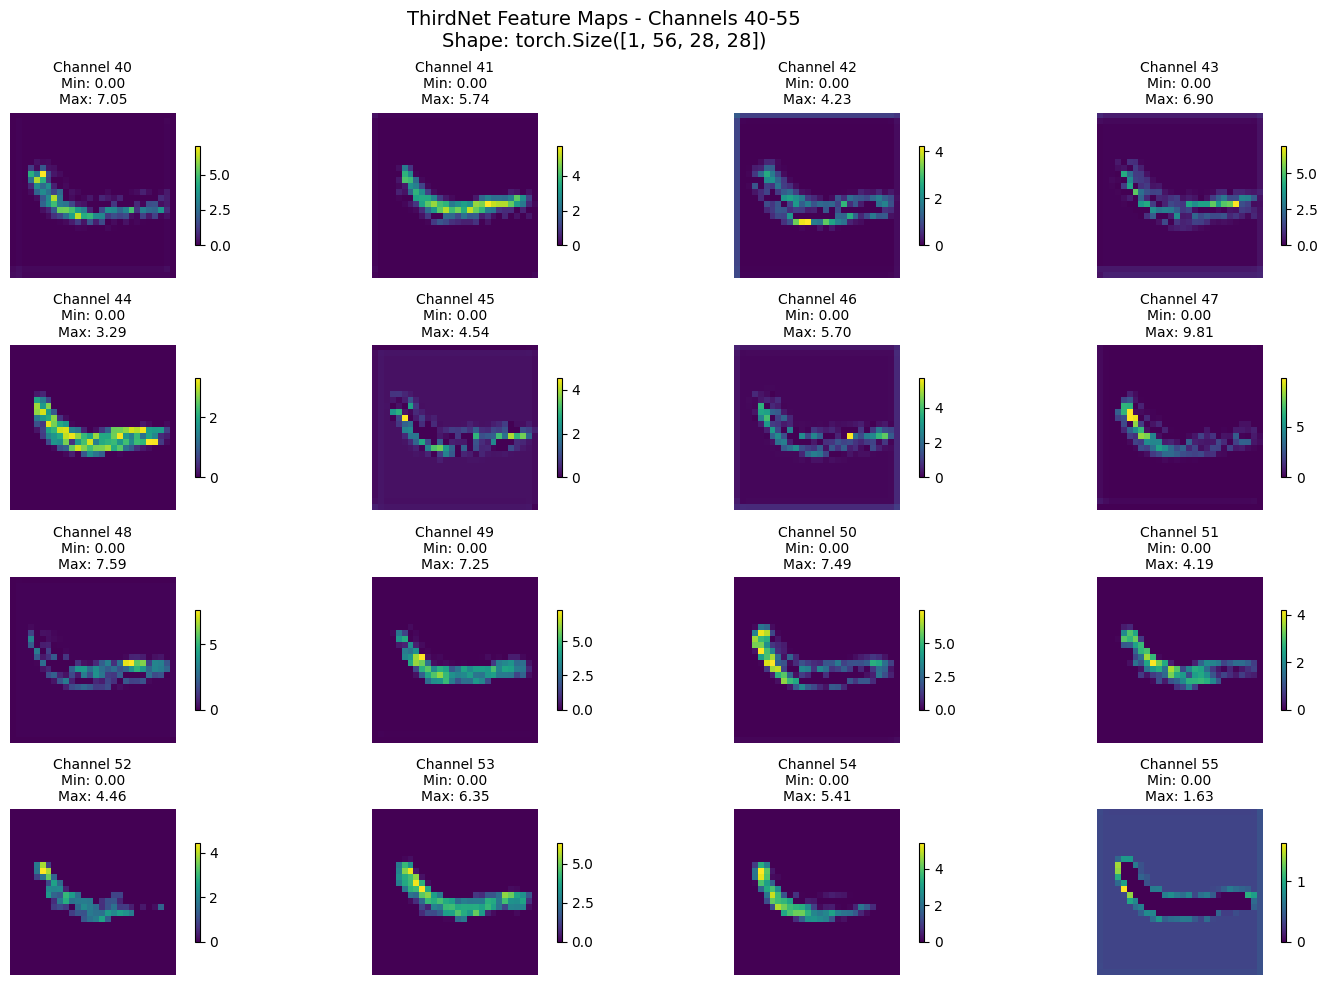

In [101]:
featmap = get_net_feature_map(model,image)
visualize_net_features(featmap, start_channel=40, max_channels=16)

Image path: ../larvae/000001_00000004.png
Predicted label for the single image: 1


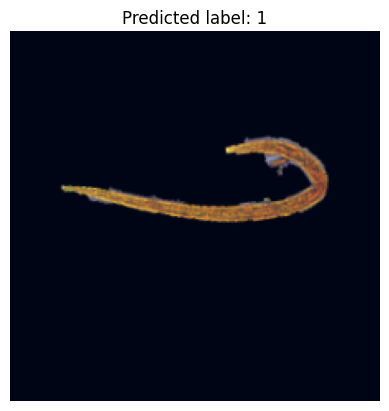

In [92]:
# Test model with a single image
def test_single_image(model, image, device):
    model.eval()
    image = image.to(device=device)
    with torch.no_grad():
        output = model(image.unsqueeze(0))  # Add batch dimension
        pred_label = torch.argmax(output, dim=1).item()
    return pred_label

# Example usage
image_idx = 31  # Index of the image you want to test
image, target = trainset[image_idx]  # Get the first image from the dataset
predicted_label = test_single_image(model, image, device)
print(f"Image path: {trainset.dataset[image_idx]}")
print(f"Predicted label for the single image: {predicted_label + 1}")
# Show image with predicted label
image = image.permute(1, 2, 0).numpy()
image = 255 * (image - np.min(image)) / (np.max(image) -np.min(image))
image = image.astype('uint8')
plt.imshow(image)
plt.title(f"Predicted label: {predicted_label + 1}")
plt.axis('off')
plt.show()

In [93]:
def generate_gradcam(model, image, target_layer, device):
    model.eval()
    image = image.unsqueeze(0).to(device)

    # Hook to capture gradients and activations
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    # Register hooks
    handle_fw = target_layer.register_forward_hook(forward_hook)
    handle_bw = target_layer.register_backward_hook(backward_hook)

    # Forward and backward
    output = model(image)
    pred_class = output.argmax(dim=1)
    model.zero_grad()
    output[0, pred_class].backward()

    # Remove hooks
    handle_fw.remove()
    handle_bw.remove()

    # Process Grad-CAM
    grads_val = gradients[0].cpu().detach().numpy()[0]
    acts_val  = activations[0].cpu().detach().numpy()[0]

    weights = np.mean(grads_val, axis=(1, 2))  # global average of gradients
    cam = np.zeros(acts_val.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * acts_val[i]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (image.shape[2], image.shape[3]))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    return cam, pred_class.item()

In [94]:
def show_image_with_heatmap(image_tensor, heatmap, label):
    image = image_tensor.permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())

    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB) / 255.0

    overlayed = 0.5 * image + 0.5 * heatmap_color

    plt.figure(figsize=(8,4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlayed)
    plt.title(f"Grad-CAM (Label: {label+1})")
    plt.axis('off')
    plt.show()

/home/pedro/Repositories/dl-larvae/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


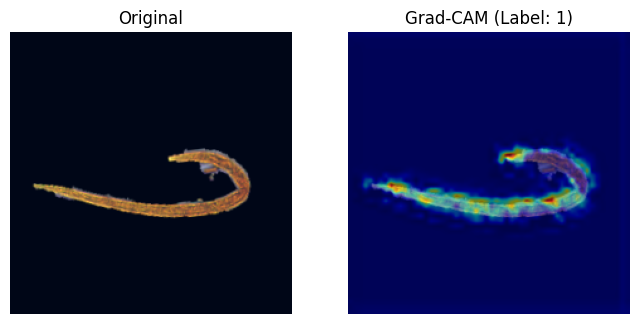

In [95]:
image, target = trainset[image_idx]
cam, pred_label = generate_gradcam(model, image, target_layer=model.incept3[0], device=device)
show_image_with_heatmap(image, cam, pred_label)

### Visualizar as projeções tSNE/UMAP da última camada convolucional e das camadas densas

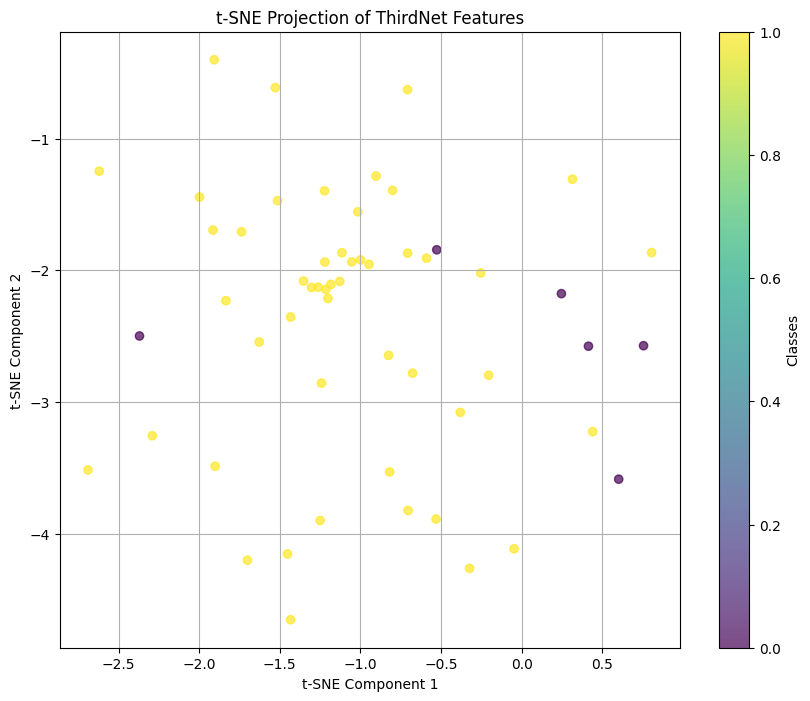

In [ ]:
# tSNE Projection

from sklearn.manifold import TSNE

def tsne_projection(model, dataloader, device, n_components=2, perplexity=30, n_iter=1000):
    model.eval()
    with torch.no_grad():
        features = []
        labels = []

        for inputs, targets in dataloader:
            inputs = inputs.to(device)

            x = model.incept1(inputs)
            x = model.incept2(x)
            x = model.incept3(x)

            features.append(x.cpu())
            labels.append(targets.cpu())

    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)

    flat_features = features.view(features.size(0), -1)

    tsne = TSNE(n_components=n_components, perplexity=perplexity)
    reduced_features = tsne.fit_transform(flat_features.numpy())

    return reduced_features, labels.numpy()


reduced_features, labels = tsne_projection(model, testload, device, n_components=2, perplexity=30)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Classes')
plt.title(f't-SNE Projection of {model_name} Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid()
plt.show()

/home/pedro/Repositories/dl-larvae/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


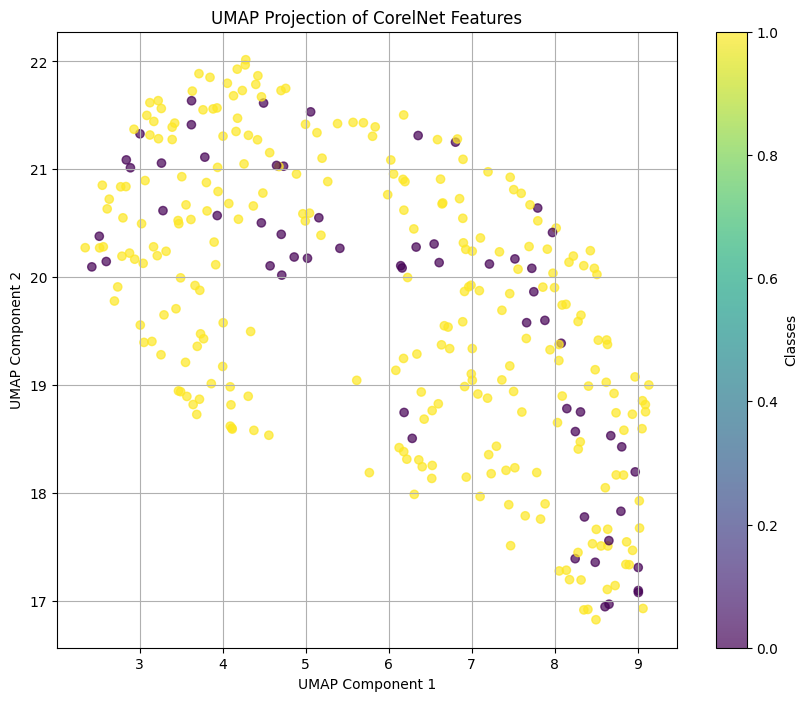

In [ ]:
# Using UMAP for dimensionality reduction

import umap

def umap_projection(model, dataloader, device, n_components=2, n_neighbors=15, min_dist=0.1):
    model.eval()
    with torch.no_grad():
        features = []
        labels = []

        for inputs, targets in dataloader:
            inputs = inputs.to(device)

            x = model.incept1(inputs)
            x = model.incept2(x)
            x = model.incept3(x)

            features.append(x.cpu())
            labels.append(targets.cpu())

    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)

    flat_features = features.view(features.size(0), -1)

    reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist)
    reduced_features = reducer.fit_transform(flat_features.numpy())

    return reduced_features, labels.numpy()

reduced_features_umap, labels_umap = umap_projection(model, trainload, device, n_components=2, n_neighbors=15, min_dist=0.1)
plt.figure(figsize=(10, 8))
scatter_umap = plt.scatter(reduced_features_umap[:, 0], reduced_features_umap[:, 1], c=labels_umap, cmap='viridis', alpha=0.7)
plt.colorbar(scatter_umap, label='Classes')
plt.title(f'UMAP Projection of {model_name} Features')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid()
plt.show()